# Experimenting with more powerful model then neighborhood methods
- Applying matrix factoization method taylored for implicit feedback where we only observe positive feedback and infer from this behavior future prefferences of the user. Since missing entries of the rating matrix do not imply that the user does not like a given item, we increase the amount of importance given to the positive ratings compared to the missing ratings. 

- Using the "implict" python software package which assumes that data is stored in a scipy spare matrix

In [11]:
import numpy as np
import pandas as pd 
from scipy import sparse
import itertools
from util import parse_playlist_dataset, create_validation_data, R_precision, plot_percentage_distribution
from implicit.als import AlternatingLeastSquares

In [12]:
import psutil
import os

def check_mem():
    # Get current process
    process = psutil.Process(os.getpid())

    # Get memory info in MB
    memory_info = process.memory_info().rss / 1024 / 1024
    print(f"Current memory usage: {memory_info:.2f} MB")

In [13]:
# DEFINE DATA PARAMETERS
VAL_START = 100
VAL_END = 110
TRAIN_START = 10
TRAIN_END = 50
TRAINING_SIZE = (TRAIN_END - TRAIN_START) * 1000

In [14]:
# DEFINE GLOBAL MAPPING FOR TRAINING INDEX (USED BY ALL FUNCTIONS)
df_song_playlist, df_tracks, _ = parse_playlist_dataset(TRAIN_START, TRAIN_END)
# _, val_tracks, _ = parse_playlist_dataset(VAL_START, VAL_END)

# lookup table to extract track names from predictions
track_uri_to_name = dict(zip(df_tracks["track_uri"], df_tracks["track_name"]))

# define mapping to unique, continuous set of playlist and track ids for the training dataset
pid_to_npid = {x:i for i, x in zip(range(len(set(df_song_playlist["pid"]))), set(df_song_playlist["pid"]))}
turi_to_tid = {x:i for i, x in zip(range(len(set(df_song_playlist["track_uri"]))), set(df_song_playlist["track_uri"]))}
tid_to_turi = {i:x for i, x in zip(range(len(set(df_song_playlist["track_uri"]))), set(df_song_playlist["track_uri"]))}

# total number of unique songs in this holdout set
print(f"Number unique tracks in training data: {len(set(df_tracks["track_uri"]))}")
# print(f"Number unique tracks in validation data: {len(set(val_tracks["track_uri"]))}")
# print(f"Number of unique tracks in that occur in both: {len(set(df_tracks["track_uri"]).intersection(set(val_tracks["track_uri"])))}")

# apply operations on training dataframe
df_song_playlist["pid"] = df_song_playlist["pid"].apply(lambda x: pid_to_npid[x])
df_song_playlist["track_uri"] = df_song_playlist["track_uri"].apply(lambda x: turi_to_tid[x])

df_song_playlist = df_song_playlist.rename(columns={"track_uri":"tid"})
df_song_playlist = df_song_playlist.drop("pos", axis=1)

print(f"Number of training playlists: {df_song_playlist["pid"].nunique()}")
print(f"Number of training songs: {df_song_playlist["tid"].nunique()}")


Number of files being extracted: 40
['spotify_train_set/data/mpd.slice.107000-107999.json', 'spotify_train_set/data/mpd.slice.108000-108999.json', 'spotify_train_set/data/mpd.slice.109000-109999.json', 'spotify_train_set/data/mpd.slice.11000-11999.json', 'spotify_train_set/data/mpd.slice.110000-110999.json', 'spotify_train_set/data/mpd.slice.111000-111999.json', 'spotify_train_set/data/mpd.slice.112000-112999.json', 'spotify_train_set/data/mpd.slice.113000-113999.json', 'spotify_train_set/data/mpd.slice.114000-114999.json', 'spotify_train_set/data/mpd.slice.115000-115999.json', 'spotify_train_set/data/mpd.slice.116000-116999.json', 'spotify_train_set/data/mpd.slice.117000-117999.json', 'spotify_train_set/data/mpd.slice.118000-118999.json', 'spotify_train_set/data/mpd.slice.119000-119999.json', 'spotify_train_set/data/mpd.slice.12000-12999.json', 'spotify_train_set/data/mpd.slice.120000-120999.json', 'spotify_train_set/data/mpd.slice.121000-121999.json', 'spotify_train_set/data/mpd.slic

In [15]:
check_mem()

Current memory usage: 2137.88 MB


In [16]:
# def process_data(df_song_playlist):
#     # apply operations on training dataframe
#     df_song_playlist["pid"] = df_song_playlist["pid"].apply(lambda x: pid_to_npid[x])
#     df_song_playlist["track_uri"] = df_song_playlist["track_uri"].apply(lambda x: turi_to_tid[x])

#     df_song_playlist = df_song_playlist.rename(columns={"track_uri":"tid"})
#     df_song_playlist = df_song_playlist.drop("pos", axis=1)

#     print(f"Number of training playlists: {df_song_playlist["pid"].nunique()}")
#     print(f"Number of training songs: {df_song_playlist["tid"].nunique()}")
    # return df_song_playlist


# df_song_playlist = process_data(df_song_playlist)


# construct sparse representation of (pid,tid) pairs from dataframe for matrix factorization algo
def construct_sparse_training_data(df_song_playlist):
    data = np.ones(len(df_song_playlist)) # marking a 1 in our sparse matrix whenever there is an interaction
    row_idx = df_song_playlist["pid"].to_numpy()
    col_idx = df_song_playlist["tid"].to_numpy()
    shape = (len(pid_to_npid), len(turi_to_tid))

    # make the sparse numpy matrix
    sparse_data = sparse.csr_matrix((data, (row_idx, col_idx)), shape=shape)
    return sparse_data

def train_matrix_factor_model(sparse_data, factors=64, regularization=0.05, alpha=2.0, iterations=15):
    model = AlternatingLeastSquares(factors=factors, regularization=regularization, alpha=alpha,iterations=iterations) # default HPs
    model.fit(sparse_data) # this model should have a 64 dimentional vector for each playlist and track
    return model

'''
Function to transform the validation dataset to use training datset mappings
If there exists a song in the validation dataset that was not seen during training, we done consider it
'''
def transform_val_data(val_data):
    new_val_data = {}

    # define a function that maps from pid, track_uri into positive integers. Apply to columns, drop pos
    turi_to_tid_f = lambda x: turi_to_tid[x] if x in turi_to_tid else -1 

    # update track id mapping to what is used by the ALS package
    # if there is a track in the validation dataset 
    for old_pid, old_songs in val_data.items():
        new_val_data[old_pid] = {"seen":list(map(turi_to_tid_f, old_songs["seen"])), 
                                        "heldout":list(map(turi_to_tid_f, old_songs["heldout"]))}    
    return new_val_data

In [17]:
def evaluate_model_vectorized(model, new_val_data):
    """Vectorized evaluation of model performance on validation dataset"""
    # Prepare data structures
    valid_playlists = []
    seen_tracks_list = []
    unseen_tracks_list = []
    k_values = []
    
    # Pre-process playlists
    for pid_val, data in new_val_data.items():
        tracks_seen = set(data["seen"]) - {-1}
        tracks_unseen = set(data["heldout"]) - {-1}
        if len(tracks_unseen) > 0:
            valid_playlists.append(pid_val)
            seen_tracks_list.append(tracks_seen)
            unseen_tracks_list.append(tracks_unseen)
            k_values.append(len(tracks_unseen))
    
    if not valid_playlists:
        return 0
    
    # Free memory
    del new_val_data
    check_mem()
    # Initialize arrays for results
    n_playlists = len(valid_playlists)
    r_precs = np.zeros(n_playlists)
    matches = np.zeros(n_playlists, dtype=int)
    total_preds = sum(k_values)
    
    # Get the maximum valid track ID
    n_items = model.item_factors.shape[0]
    
    # Process in batches to reduce memory usage
    batch_size = 1000  # Adjust based on available memory
    for batch_start in range(0, n_playlists, batch_size):
        check_mem()
        batch_end = min(batch_start + batch_size, n_playlists)
        
        # Compute user representations for this batch
        batch_user_reps = np.zeros((batch_end - batch_start, model.factors))
        for i in range(batch_start, batch_end):
            tracks_seen = seen_tracks_list[i - batch_start]
            if tracks_seen:  # Skip empty sets
                # Filter out invalid track IDs
                valid_tracks = [t for t in tracks_seen if 0 <= t < n_items]
                if valid_tracks:  # Only proceed if there are valid tracks
                    batch_user_reps[i - batch_start] = np.sum(model.item_factors[valid_tracks], axis=0)
        
        # Compute similarities for this batch
        batch_similarities = batch_user_reps @ model.item_factors.T
        
        # Process recommendations for this batch
        for i in range(batch_start, batch_end):
            batch_idx = i - batch_start
            sim = batch_similarities[batch_idx].copy()  # Create a copy to avoid modifying original
            
            # Mask out seen tracks - only valid indices
            for track_id in seen_tracks_list[batch_idx]:
                if 0 <= track_id < n_items:  # Check if index is valid
                    sim[track_id] = float('-inf')
            
            # Get top-k recommendations
            k = k_values[batch_idx]
            song_recs = np.argsort(-sim)[:k]
            
            # Compute precision
            try:
                r_prec, match = R_precision(set(song_recs), unseen_tracks_list[batch_idx])
                r_precs[i] = r_prec
                matches[i] = match
            except Exception as e:
                print(f"Error computing R_precision for playlist {i}: {e}")
        
        # Free memory after processing each batch
        del batch_user_reps
        del batch_similarities
    
    # Compute summary statistics
    total_matches = np.sum(matches)
    percentage_hit = total_matches / total_preds if total_preds > 0 else 0
    max_r_prec = np.max(r_precs) if len(r_precs) > 0 else 0
    
    print(f"Percentage Hit: {percentage_hit}")
    print(f"Max r_prec on a given playlist: {max_r_prec}")
    
    # Only plot if there are valid scores
    scores_np = r_precs * 100
    try:
        plot_percentage_distribution(scores_np)
    except Exception as e:
        print(f"Warning: Unable to plot distribution: {e}")
    
    return percentage_hit

In [18]:
!export OPENBLAS_NUM_THREADS=1

In [19]:
check_mem()

Current memory usage: 2138.09 MB


Current memory usage: 2148.59 MB
Hyper parameter values (factor,reg,alpha,iters): (150, 1, 40, 40)


100%|██████████| 40/40 [04:40<00:00,  7.02s/it]


Current memory usage: 2344.06 MB
Number of files being extracted: 10
['spotify_train_set/data/mpd.slice.189000-189999.json', 'spotify_train_set/data/mpd.slice.19000-19999.json', 'spotify_train_set/data/mpd.slice.190000-190999.json', 'spotify_train_set/data/mpd.slice.191000-191999.json', 'spotify_train_set/data/mpd.slice.192000-192999.json', 'spotify_train_set/data/mpd.slice.193000-193999.json', 'spotify_train_set/data/mpd.slice.194000-194999.json', 'spotify_train_set/data/mpd.slice.195000-195999.json', 'spotify_train_set/data/mpd.slice.196000-196999.json', 'spotify_train_set/data/mpd.slice.197000-197999.json']
Current memory usage: 2442.03 MB
Current memory usage: 2460.64 MB
Current memory usage: 2460.64 MB
Current memory usage: 2049.02 MB
Current memory usage: 2031.94 MB
Current memory usage: 1805.05 MB
Current memory usage: 1597.58 MB
Current memory usage: 1592.12 MB
Current memory usage: 1601.66 MB
Current memory usage: 1501.66 MB
Current memory usage: 1517.48 MB
Current memory usag

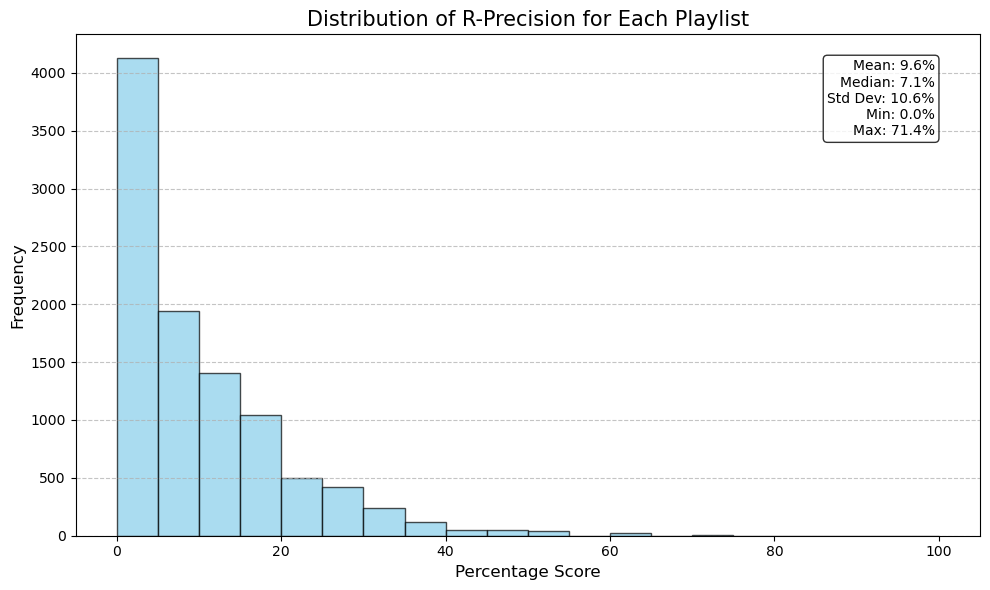

Current memory usage: 1069.53 MB


In [20]:
# def main():

# best pair from validation data -> (100, 0.1, 15, 25)
best_cnfg = {
    'factors': 150,
    'regularization': 1,
    'alpha': 40,
    'iterations': 40,
}

# best_cnfg['iterations'] = 1

# for a fixed size training dataset, experiment with different hyperparameters
sparse_data = construct_sparse_training_data(df_song_playlist)
del df_song_playlist

# keys, values = zip(*hyperparameter_grid.items())
# hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
# print(len(hyperparameter_combinations))

results = {}
# for params in hyperparameter_combinations:
hps = tuple(best_cnfg.values())

check_mem()

print(f"Hyper parameter values (factor,reg,alpha,iters): {hps}")
model = train_matrix_factor_model(sparse_data, **best_cnfg)

check_mem()

new_val_data = transform_val_data(create_validation_data(VAL_START,VAL_END))

check_mem()

score = evaluate_model_vectorized(model, new_val_data)

check_mem()

results[hps] = score
# return results